In [4]:
from tensorflow.keras.models import load_model
from data_preprocessing import Preprocessing
from LSTM_model import LSTM_model
import pandas as pd
import argparse



# Load and preprocess the dataset
preprocessing = Preprocessing(dataset_path='/home/groovyjac/projects/autonomous-portfolio-management/main_data_store_JDKv1.h5')
dataset = preprocessing.load_dataset()
returns = preprocessing.select_most_traded_stocks(dataset)
T = 52  # weeks
data = preprocessing.create_sliding_window(returns, T)

lstm_model = LSTM_model(data)
X_train, y_train, X_test, y_test = lstm_model.prepare_data()

# Load the trained LSTM model from the saved .h5 file
lstm_model = load_model('lstm.regression.h5')

# Assuming you have prepared X_test (input features) and y_test (true labels) for evaluation
# Make predictions on the test dataset
test_predictions = lstm_model.predict(X_test).squeeze()

# Evaluate the model performance (Mean Squared Error) on the test dataset
mse = lstm_model.evaluate(X_test, y_test, verbose=0)

2023-04-07 00:16:57.509678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-07 00:16:57.511437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-07 00:16:57.512443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

698/698 [==============================] - 6s 7ms/step


2023-04-07 00:17:03.899394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-07 00:17:03.900558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-07 00:17:03.901664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

/tmp/ipykernel_28987/3323144177.py:14: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['deciles'] = by_date.y_pred.apply(pd.qcut, q=5, labels=False, duplicates='drop')


1.94 (0.37%)


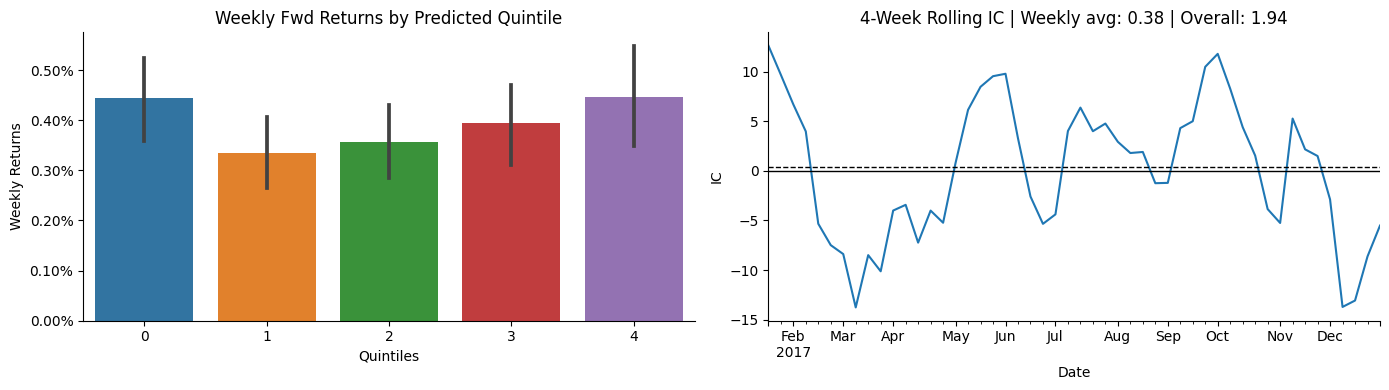

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from matplotlib.ticker import FuncFormatter

# Convert the test_predictions and y_test to a DataFrame
df = y_test.to_frame('ret').assign(y_pred=test_predictions)

# Group the DataFrame by 'date' (assuming y_test has a MultiIndex with 'date' as one of the levels)
by_date = df.groupby(level='date')

# Calculate deciles based on predicted values
df['deciles'] = by_date.y_pred.apply(pd.qcut, q=5, labels=False, duplicates='drop')

# Calculate the Information Coefficient (IC)
ic = by_date.apply(lambda x: spearmanr(x.ret, x.y_pred)[0]).mul(100)

# Convert test_predictions to DataFrame and save to HDF5 file
test_predict = pd.DataFrame(test_predictions, columns=['prediction'], index=y_test.index)
test_predict.index.names = ['symbol', 'date']
test_predict.to_hdf('results/predictions.h5', 'predictions')

# Calculate the overall IC and p-value
rho, p = spearmanr(df.ret, df.y_pred)
print(f'{rho*100:.2f} ({p:.2%})')

# Plot the results
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.barplot(x='deciles', y='ret', data=df, ax=axes[0])
axes[0].set_title('Weekly Fwd Returns by Predicted Quintile')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
axes[0].set_ylabel('Weekly Returns')
axes[0].set_xlabel('Quintiles')

avg_ic = ic.mean()
title = f'4-Week Rolling IC | Weekly avg: {avg_ic:.2f} | Overall: {rho*100:.2f}'
ic.rolling(4).mean().dropna().plot(ax=axes[1], title=title)
axes[1].axhline(avg_ic, ls='--', c='k', lw=1)
axes[1].axhline(0, c='k', lw=1)
axes[1].set_ylabel('IC')
axes[1].set_xlabel('Date')

sns.despine()
fig.tight_layout()
fig.savefig('results/lstm_reg.png')  # Save the plot as an image file

In [11]:
test_predict.tail()

prediction
symbol date                  
ZION   2017-12-03    0.003215
       2017-12-10   -0.000878
       2017-12-17    0.002401
       2017-12-24    0.000413
       2017-12-31    0.001921

/tmp/ipykernel_28987/1845260910.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['smoothed_ret'] = df_selected.groupby('ticker')['ret'].rolling(window=window_size).mean().reset_index(level=0, drop=True)


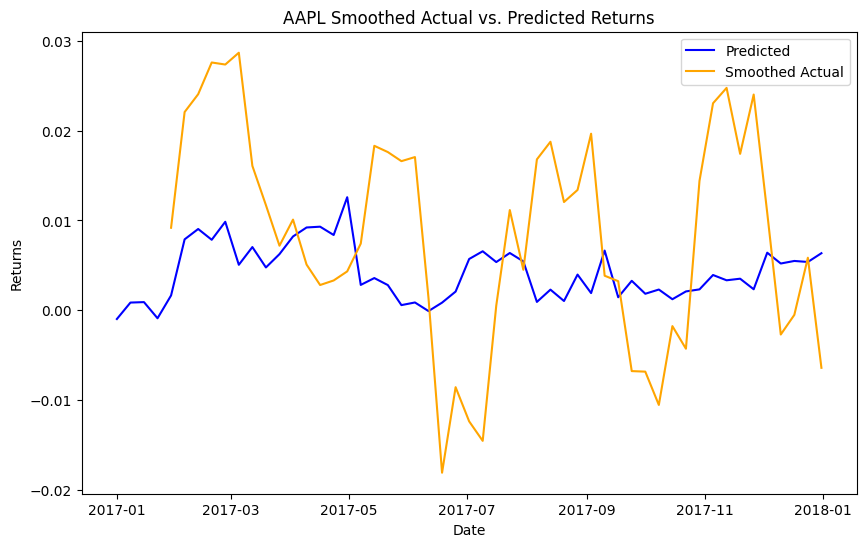

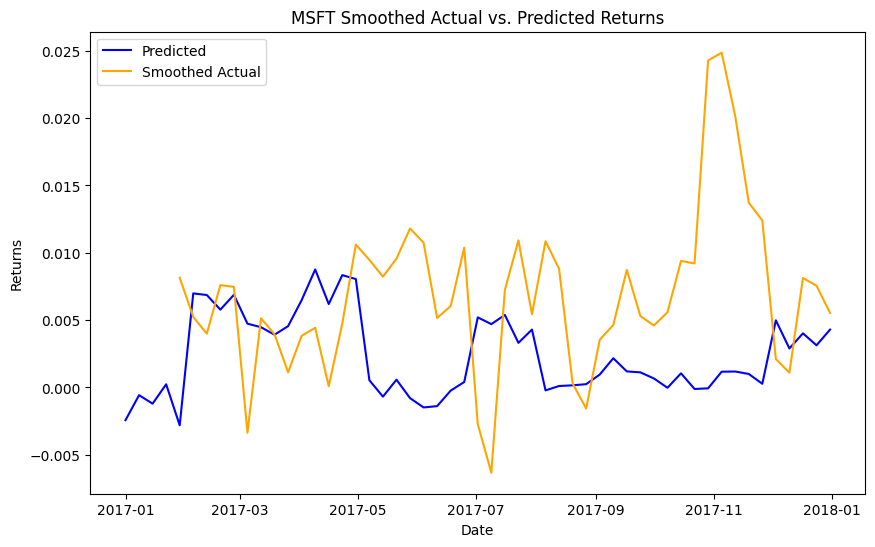

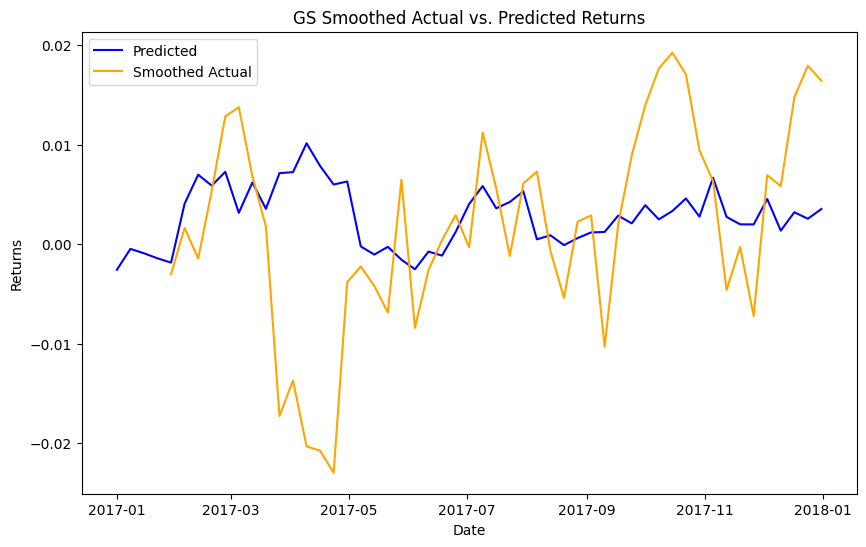

In [23]:
import matplotlib.pyplot as plt

# Select three specific stocks (e.g., 'AAPL', 'MSFT', 'GOOG')
selected_stocks = ['AAPL', 'MSFT', 'GS']
df_selected = df.loc[df.index.get_level_values('ticker').isin(selected_stocks)]

# Define the window size for smoothing (e.g., 5 periods)
window_size = 5

# Calculate the smoothed predicted returns using a rolling window
df_selected['smoothed_ret'] = df_selected.groupby('ticker')['ret'].rolling(window=window_size).mean().reset_index(level=0, drop=True)

# Plot the actual vs. smoothed predicted values for each selected stock
for stock in selected_stocks:
    stock_data = df_selected.loc[df_selected.index.get_level_values('ticker') == stock]
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(stock_data.index.get_level_values('date'), stock_data['y_pred'], label='Predicted', color='blue')
    ax.plot(stock_data.index.get_level_values('date'), stock_data['smoothed_ret'], label='Smoothed Actual', color='orange')
    ax.set_title(f'{stock} Smoothed Actual vs. Predicted Returns')
    ax.set_xlabel('Date')
    ax.set_ylabel('Returns')
    ax.legend()
    plt.show()
    plt.show()

/tmp/ipykernel_28987/2784400798.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['signal'] = np.where(stock_data['y_pred'] > 0, 1, -1)
/tmp/ipykernel_28987/2784400798.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['portfolio_returns'] = stock_data['signal'] * stock_data['ret']
/tmp/ipykernel_28987/2784400798.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

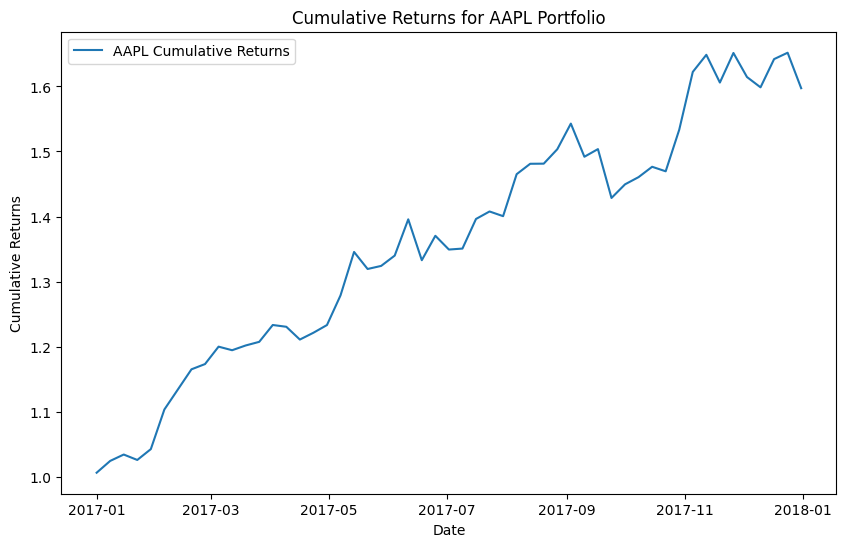

In [22]:
import numpy as np

# Select the data for Apple (AAPL)
stock_data = df.loc[df.index.get_level_values('ticker') == 'AAPL']

# Create a signal column: 1 for positive prediction, -1 for negative prediction
stock_data['signal'] = np.where(stock_data['y_pred'] > 0, 1, -1)

# Calculate the portfolio returns (signal * actual returns)
stock_data['portfolio_returns'] = stock_data['signal'] * stock_data['ret']

# Calculate the cumulative returns for the portfolio
stock_data['cumulative_returns'] = (1 + stock_data['portfolio_returns']).cumprod()

# Plot the cumulative returns for the portfolio
plt.figure(figsize=(10, 6))
plt.plot(stock_data.index.get_level_values('date'), stock_data['cumulative_returns'], label='AAPL Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns for AAPL Portfolio')
plt.legend()
plt.show()

/tmp/ipykernel_28987/3529423936.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['signal'] = np.where(stock_data['y_pred'] > 0, 1, -1)
/tmp/ipykernel_28987/3529423936.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['portfolio_returns'] = stock_data['signal'] * stock_data['ret']
/tmp/ipykernel_28987/3529423936.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

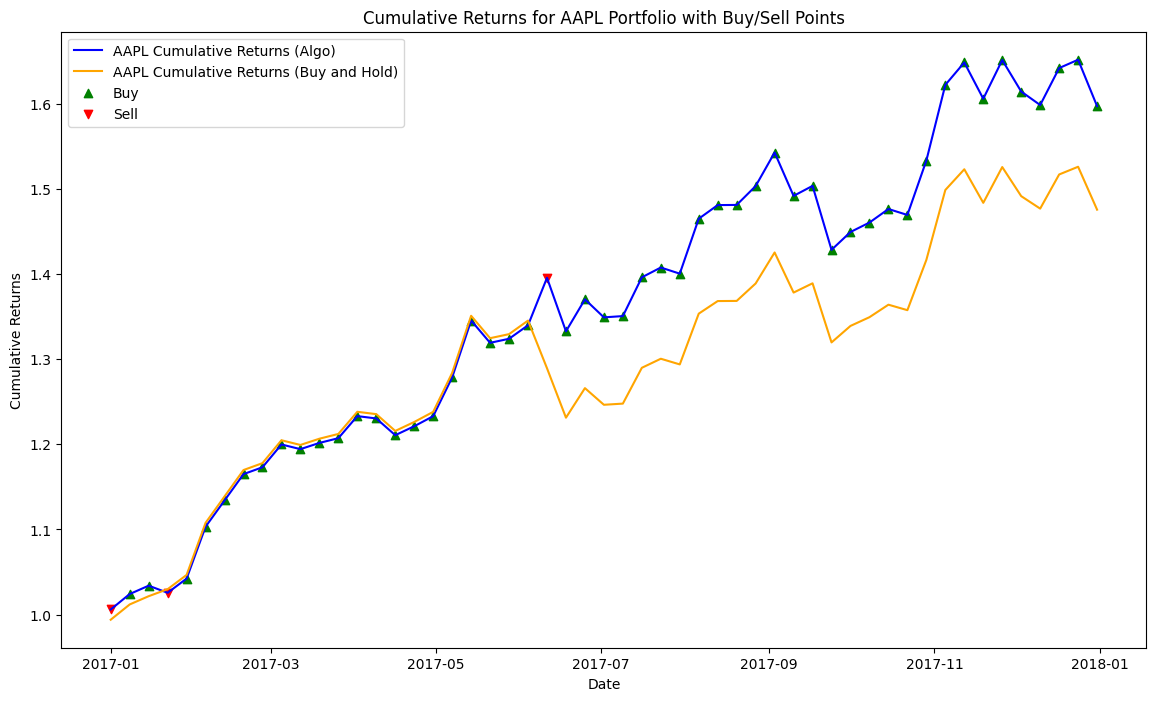

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Select the data for Apple (AAPL)
stock_data = df.loc[df.index.get_level_values('ticker') == 'AAPL']

# Create a signal column: 1 for positive prediction, -1 for negative prediction
stock_data['signal'] = np.where(stock_data['y_pred'] > 0, 1, -1)

# Calculate the portfolio returns (signal * actual returns)
stock_data['portfolio_returns'] = stock_data['signal'] * stock_data['ret']

# Calculate the cumulative returns for the portfolio
stock_data['cumulative_returns'] = (1 + stock_data['portfolio_returns']).cumprod()

# Calculate the cumulative returns for the buy-and-hold strategy
stock_data['cumulative_returns_hold'] = (1 + stock_data['ret']).cumprod()

# Plot the cumulative returns for the portfolio
plt.figure(figsize=(14, 8))
plt.plot(stock_data.index.get_level_values('date'), stock_data['cumulative_returns'], label='AAPL Cumulative Returns (Algo)', color='blue')

# Plot the cumulative returns for the buy-and-hold strategy
plt.plot(stock_data.index.get_level_values('date'), stock_data['cumulative_returns_hold'], label='AAPL Cumulative Returns (Buy and Hold)', color='orange')

# Mark buy points on the plot
buy_points = stock_data[stock_data['signal'] == 1]
plt.scatter(buy_points.index.get_level_values('date'), buy_points['cumulative_returns'], color='green', marker='^', label='Buy')

# Mark sell points on the plot
sell_points = stock_data[stock_data['signal'] == -1]
plt.scatter(sell_points.index.get_level_values('date'), sell_points['cumulative_returns'], color='red', marker='v', label='Sell')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns for AAPL Portfolio with Buy/Sell Points')
plt.legend()
plt.show()